In [2]:
import glob
import re
import matplotlib as plt
import numpy as np
import scipy as sp
import xarray as xr
import intake
import intake_esm
import pandas as pd

In [1]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
######## File paths ################
lustre_scratch    = "/lustre/desc1/scratch/harshah"
gdex_data         = "/gdex/data/special_projects/pythia_2024"
#########
gdex_url           = 'https://data.gdex.ucar.edu/'
era5_catalog      = gdex_url + 'special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json'
#
##########
print(era5_catalog)

https://data.gdex.ucar.edu/special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json


In [4]:
USE_PBS_SCHEDULER = True

In [5]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = lustre_scratch + '/dask/spill',
        log_directory = lustre_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

In [6]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40641 instead
  warnings.warn(


In [7]:
# Scale the cluster and display cluster dashboard URL
n_workers =5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(71ce1944, 'tcp://128.117.208.96:36603', workers=5, threads=5, memory=20.00 GiB)

## Load data 

In [37]:
date = '20210214'
hour = '12'
var = 'TMP'
level = '2m_above_ground'
url1 = 'osdf:///aws-opendata/us-west-1/hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var + '/' + level
url2 = 'osdf:///aws-opendata/us-west-1/hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var

In [38]:
print(url1)

osdf:///aws-opendata/us-west-1/hrrrzarr/sfc/20210214/20210214_12z_anl.zarr/2m_above_ground/TMP/2m_above_ground


In [41]:
%%time
temps = xr.open_zarr(url1)
temps

CPU times: user 3.78 ms, sys: 2.21 ms, total: 5.99 ms
Wall time: 28.6 ms


<xarray.Dataset> Size: 4MB
Dimensions:  (projection_y_coordinate: 1059, projection_x_coordinate: 1799)
Dimensions without coordinates: projection_y_coordinate, projection_x_coordinate
Data variables:
    TMP      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>

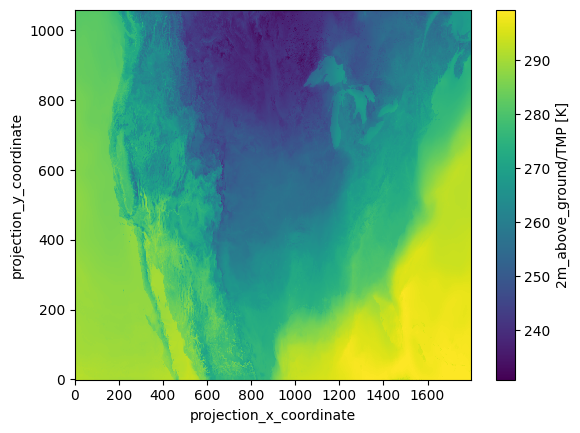

In [42]:
%%time
temps.TMP.plot()

In [ ]:
cluster.close()